In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from get_from_web import get_from_web

In [4]:
#GET TOTAL DEATHS file from web/hdd
"""Karlinsky & Kobak 2021, 
Tracking excess mortality across countries during the COVID-19 pandemic with the World Mortality Dataset, 
eLife https://doi.org/10.7554/eLife.69336"""
f2save = 'world_mortality.csv'
download_url = 'https://raw.githubusercontent.com/akarlinsky/world_mortality/main/' + f2save

if True:
    ret_code, _ = get_from_web(download_url, f2save=f2save)
    print(ret_code)

#GET file from hdd
df = pd.read_csv(f2save)
df.rename(columns={'time':'week'}, inplace=True)
df.set_index('week', inplace=True)

1


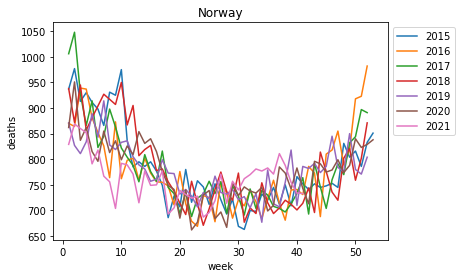

In [35]:
#visualize per available years & given country
country = 'Norway'

mask = df['country_name']==country
df_tmp = df[mask].pivot(columns='year', values='deaths')

ax = df_tmp.plot(title=country, ylabel='deaths') 
ax.legend(bbox_to_anchor=(1.0, 1.0))

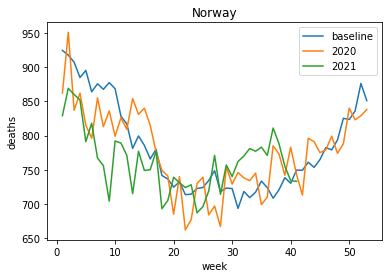

In [36]:
#add baseline
df_tmp['baseline'] = df_tmp[[2015,2016,2017,2018,2019]].mean(axis=1)

ax = df_tmp[['baseline',2020,2021]].plot(title=country, ylabel='deaths') 
ax.legend(bbox_to_anchor=(1.0, 1.0))

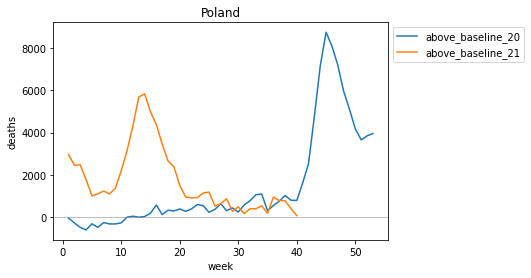

In [17]:
#calculate excessive deaths
df_tmp['above_baseline_20'] = df_tmp[2020]-df_tmp['baseline'] 
df_tmp['above_baseline_21'] = df_tmp[2021]-df_tmp['baseline']

ax = df_tmp[['above_baseline_20','above_baseline_21']].plot(title=country, ylabel='deaths') 
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.axhline(0, color='gray', linewidth=0.5)

In [19]:
#GET population data from web
f2save = 'population.xls'
download_url = 'https://api.worldbank.org/v2/en/indicator/SP.POP.TOTL?downloadformat=excel'

if True:
    ret_code, _ = get_from_web(download_url, f2save=f2save)
    print(ret_code)

#GET file from hdd
dp = pd.read_excel(f2save, header=3)
#align some country names to match those from df
dp['Country Name'].replace({'Czech Republic':'Czechia', 'Iran, Islamic Rep.':'Iran', 'Slovak Republic':'Slovakia', 'Korea, Rep.':'South Korea', 'Russian Federation':'Russia', 'Egypt, Arab Rep.':'Egypt', 'Hong Kong SAR, China':'Hong Kong'}, inplace=True)

1


In [32]:
death_dict = {}
countries = df.country_name.unique()
#countries = ['Poland']
for country in countries:
    #print(country)

    mask = df['country_name']==country
    df_tmp = df[mask].pivot(columns='year', values='deaths')
    
    #baseline = average per week 5 previous years
    if (2015 not in df_tmp.columns) or (2016 not in df_tmp.columns) or (2017 not in df_tmp.columns) or (2018 not in df_tmp.columns) or (2019 not in df_tmp.columns):
        continue
    df_tmp['baseline'] = df_tmp[[2015,2016,2017,2018,2019]].mean(axis=1)
    
    #plot
    if False:
        ax = df_tmp[['baseline',2020,2021]].plot(title=country) 
        ax.legend(bbox_to_anchor=(1.0, 1.0))
    
    #skip if no weekly data eg. monthly
    """
    if df['time_unit'][mask].iloc[0] != 'weekly':
        print('%s only monthly' %(country))
        continue
    """
    #get population data from dp
    mask = dp['Country Name'] == country
    if ~mask.any():
        #print('%s not found in population db' %(country))
        continue
    pop = dp.loc[mask, '2020'].iloc[0]


    #various statistics
    if (2020 not in df_tmp.columns) or (2021 not in df_tmp.columns):
        continue
    df_tmp['above_baseline_20'] = df_tmp[2020]-df_tmp['baseline'] 
    df_tmp['above_baseline_21'] = df_tmp[2021]-df_tmp['baseline']

    #do not count weeks without data
    mask_nan = df_tmp['above_baseline_21'].isna()

    death_dict[country] = {
        'baseline':df_tmp['baseline'].sum().astype(int),
        'excessive_deaths_20':df_tmp['above_baseline_20'].sum().astype(int), 
        'excessive_deaths_21':df_tmp['above_baseline_21'][~mask_nan].sum().astype(int),
        'excessive_deaths':df_tmp['above_baseline_20'].sum().astype(int)+df_tmp['above_baseline_21'][~mask_nan].sum().astype(int),
        'population_21': pop}

df_deaths = pd.DataFrame(death_dict).T
for col in df_deaths.columns:
    if 'population' in col:
        continue
    df_deaths[col+'_%'] = (100 * df_deaths[col] / df_deaths['population_21']).round(3)

df_deaths

,baseline,excessive_deaths_20,excessive_deaths_21,excessive_deaths,population_21,baseline_%,excessive_deaths_20_%,excessive_deaths_21_%,excessive_deaths_%
Albania,21955.0,5649.0,3956.0,9605.0,2837743.0,0.774,0.199,0.139,0.338
Armenia,27047.0,8323.0,2769.0,11092.0,2963234.0,0.913,0.281,0.093,0.374
Australia,143006.0,997.0,5033.0,6030.0,25687041.0,0.557,0.004,0.020,0.023
Austria,82563.0,8989.0,4013.0,13002.0,8917205.0,0.926,0.101,0.045,0.146
Azerbaijan,57037.0,18609.0,9857.0,28466.0,10110116.0,0.564,0.184,0.097,0.282
...,...,...,...,...,...,...,...,...,...
Ukraine,584265.0,32569.0,46576.0,79145.0,44134693.0,1.324,0.074,0.106,0.179
United Kingdom,612853.0,83850.0,42306.0,126156.0,67215293.0,0.912,0.125,0.063,0.188
United States,2840964.0,600000.0,417099.0,1017099.0,329484123.0,0.862,0.182,0.127,0.309
Uruguay,33869.0,-1231.0,5796.0,4565.0,3473727.0,0.975,-0.035,0.167,0.131


In [33]:
cols = ['excessive_deaths_%', 'baseline_%', 'excessive_deaths']
df_deaths[cols].sort_values('excessive_deaths_%', ascending=False).head(10)

excessive_deaths_%         0.4609
baseline_%                 0.9035
excessive_deaths      173689.5000
dtype: float64

All columns
['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'ne

In [34]:
cols = ['excessive_deaths_%', 'baseline_%', 'excessive_deaths']
df_deaths[cols].sort_values('excessive_deaths_%', ascending=False).tail(10).mean()

excessive_deaths_%       0.0102
baseline_%               0.5667
excessive_deaths      1962.3000
dtype: float64

In [29]:
df_deaths[cols].mean()

excessive_deaths_%        0.201817
baseline_%                0.833805
excessive_deaths      73372.024390
dtype: float64

In [ ]:
#df_deaths.sort_values('excessive_deaths_%', ascending=False).tail(10).plot(y='excessive_deaths_%', kind='barh')
df_deaths.sort_values('excessive_deaths_%', ascending=False).head(20).plot(y='excessive_deaths_%', kind='barh')